<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/PJ_Movie_recommendation_System_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Recommender system Kaggle

In [104]:
# Load basic library
import re
import numpy as np
import time
import pandas as pd
from tensorflow import random
from sklearn.externals import joblib 
from scipy import stats

# import require packages for plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 
import plotly
from plotly import tools
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import altair as alt

There are basically three types of recommender systems:-

Demographic Filtering- They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Content Based Filtering- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

Collaborative Filtering- This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

In [105]:
df1=pd.read_csv('/content/drive/My Drive/Data/tmdb_5000_credits.csv')
df2=pd.read_csv('/content/drive/My Drive/Data/tmdb_5000_movies.csv')

The first dataset contains the following features:-

- movie_id - A unique identifier for each movie.
- cast - The name of lead and supporting actors.
- crew - The name of Director, Editor, Composer, Writer etc.

The second dataset has the following features:-

- budget - The budget in which the movie was made.
- genre - The genre of the movie, Action, Comedy ,Thriller etc.
- homepage - A link to the homepage of the movie.
- id - This is infact the movie_id as in the first dataset.
- keywords - The keywords or tags related to the movie.
- original_language - The language in which the movie was made.
- original_title - The title of the movie before translation or adaptation.
- overview - A brief description of the movie.
- popularity - A numeric quantity specifying the movie popularity.
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date on which it was released.
- revenue - The worldwide revenue generated by the movie.
- runtime - The running time of the movie in minutes.
- status - "Released" or "Rumored".
- tagline - Movie's tagline.
- title - Title of the movie.
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

Let's join the two dataset on the 'id' column

In [106]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [107]:
df2.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [108]:
df2.shape

(4803, 23)

# Demographic Filtering

Before getting started with this -

- we need a metric to score or rate movie
- Calculate the score for every movie
- Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

where,

- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie; And
- C is the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [109]:
df2.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [110]:
C= df2['vote_average'].mean()
C

6.092171559442011

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [111]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [112]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [113]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [114]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1) # x is df each row

In [115]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 10 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Hurray! We have made our first(though very basic) recommender. Under the Trending Now tab of these systems we find movies that are very popular and they can just be obtained by sorting the dataset by the popularity column.

Text(0.5, 1.0, 'Popular Movies')

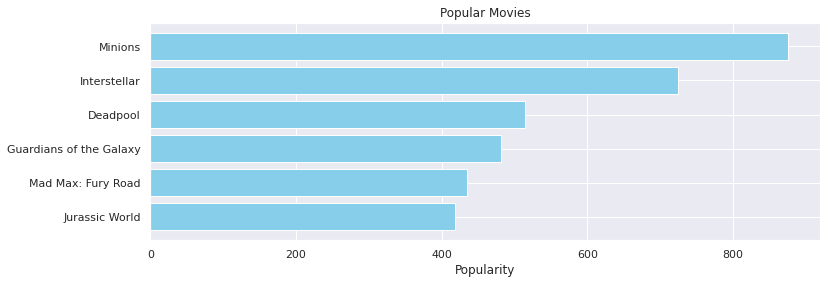

In [116]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Now something to keep in mind is that these demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. This is when we move on to a more refined system- Content Basesd Filtering.

# Content Based Filtering

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

## Plot description based Recommender

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the overview feature of our dataset. Let's take a look at the data. ..

In [117]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

For any of you who has done even a bit of text processing before knows we need to convert the word vector of each overview. Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it?

In [118]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

TF-IDF là gì?

TF-IDF (Term Frequency – Inverse Document Frequency) là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản. Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu. Một vài biến thể của tf-idf thường được sử dụng trong các hệ thống tìm kiếm như một công cụ chính để đánh giá và sắp xếp văn bản dựa vào truy vấn của người dùng.  Tf-idf cũng được sử dụng để lọc những từ stopwords trong các bài toán như tóm tắt văn bản và phân loại văn bản.

Sau đây, chúng ta sẽ đi chi tiết vào từng thành phần. Và sau đó, chúng ta đi đến công thức tính tf-idf. Cuối cùng là những ví dụ sinh động để các bạn hiểu sâu và kỹ về TF-IDF là gì.

TF là gì?
TF: Term Frequency(Tần suất xuất hiện của từ) là số lần từ xuất hiện trong văn bản. Vì các văn bản có thể có độ dài ngắn khác nhau nên một số từ có thể xuất hiện nhiều lần trong một văn bản dài hơn là một văn bản ngắn. Như vậy, term frequency thường được chia cho độ dài văn bản( tổng số từ trong một văn bản).

IDF là gì?
IDF: Inverse Document Frequency(Nghịch đảo tần suất của văn bản), giúp đánh giá tầm quan trọng của một từ . Khi tính toán TF , tất cả các từ được coi như có độ quan trọng bằng nhau. Nhưng  một số từ như “is”, “of” và “that” thường xuất hiện rất nhiều lần nhưng độ quan trọng là không cao. Như thế chúng ta cần giảm độ quan trọng của những từ này xuống.

In [119]:
#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

In [120]:
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])
print(tfidf_matrix.shape)
tfidf_matrix

(4803, 20978)


<4803x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 125840 stored elements in Compressed Sparse Row format>

In [121]:
df2.shape

(4803, 23)

In [122]:
df2['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

Có 4803 overall review từng phim, mỗi review này sẽ được vecto thành từng từ .vd: review phim 0 có 15 từ được vector, mỗi từ có vị trí của nó trong 20978 từ trong toàn văn bản, được chấm score TFIDF dựa vào frequency của nó trong document và trong toàn bộ documents

In [123]:
print(tfidf_matrix)


  (0, 3545)	0.27493285363270825
  (0, 795)	0.2084074203878777
  (0, 14754)	0.26556705630591243
  (0, 13355)	0.2537072195025191
  (0, 7414)	0.2153609580612842
  (0, 19054)	0.23864791282019557
  (0, 12269)	0.1778447209530258
  (0, 19671)	0.24152597853522884
  (0, 13644)	0.29248619979162926
  (0, 12411)	0.27155366980600426
  (0, 5519)	0.27863433071832444
  (0, 11667)	0.2580267910376776
  (0, 13680)	0.3411386462681145
  (0, 3232)	0.19886014555883547
  (0, 225)	0.3055534742040413
  (1, 14969)	0.2764509091386784
  (1, 18376)	0.37466189442120984
  (1, 6188)	0.2743698871995736
  (1, 19418)	0.3060153616124342
  (1, 6016)	0.1966138874334538
  (1, 6069)	0.2948248727159851
  (1, 8674)	0.2809447973706985
  (1, 11025)	0.12158034118460531
  (1, 3843)	0.19195626583733216
  (1, 4854)	0.19967394354414503
  :	:
  (4802, 5841)	0.34247058916908363
  (4802, 4576)	0.15002600185636672
  (4802, 10126)	0.15121328276821538
  (4802, 16409)	0.17123529458454181
  (4802, 4816)	0.14223771161926407
  (4802, 1311)	0.16

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [124]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [125]:
print(cosine_sim.shape)
cosine_sim

(4803, 4803)


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [126]:
df2.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802],
           dtype='int64', length=4803)

In [127]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

We are now in a good position to define our recommendation function. These are the following steps we'll follow :

- Get the index of the movie given its title.

- Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
- Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
- Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
- Return the titles corresponding to the indices of the top elements.

In [128]:
# Get the index of the movie that matches the title
title='The Dark Knight Rises'
idx = indices[title]
idx

3

In [129]:
print(len(cosine_sim[idx]))
cosine_sim[idx]

4803


array([0.02499512, 0.        , 0.        , ..., 0.03386366, 0.04275232,
       0.02269198])

In [130]:
# Get the pairwsie similarity scores of all movies with that movie
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores

[(0, 0.0249951158376727),
 (1, 0.0),
 (2, 0.0),
 (3, 1.0),
 (4, 0.010433403719159354),
 (5, 0.0051446018158107934),
 (6, 0.01260063243546246),
 (7, 0.026954270578912674),
 (8, 0.02065221688538951),
 (9, 0.1337400906655523),
 (10, 0.0),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.004071333922512107),
 (16, 0.021121093874993183),
 (17, 0.0),
 (18, 0.006768893195007471),
 (19, 0.010765175685064708),
 (20, 0.007178266390761152),
 (21, 0.033380775071488206),
 (22, 0.0),
 (23, 0.0),
 (24, 0.019238168304196293),
 (25, 0.017013388161368177),
 (26, 0.018845673291717265),
 (27, 0.0),
 (28, 0.008351231142809445),
 (29, 0.02582248131068942),
 (30, 0.017549884233472455),
 (31, 0.029947529512076927),
 (32, 0.021708602796233892),
 (33, 0.0),
 (34, 0.0),
 (35, 0.0),
 (36, 0.028418448812136628),
 (37, 0.0),
 (38, 0.030631547964966054),
 (39, 0.01088522587631032),
 (40, 0.0),
 (41, 0.021109848007927),
 (42, 0.008087287409335878),
 (43, 0.0),
 (44, 0.0),
 (45, 0.008667206203132952),
 (46, 0.0

In [131]:
# Sort the movies based on the similarity scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores

[(3, 1.0),
 (65, 0.30151176591665485),
 (299, 0.29857045255396825),
 (428, 0.2878505467001694),
 (1359, 0.264460923827995),
 (3854, 0.18545003006561456),
 (119, 0.16799626199850706),
 (2507, 0.16682891043358278),
 (9, 0.1337400906655523),
 (1181, 0.13219702138476813),
 (210, 0.13045537014449818),
 (879, 0.1050189187666832),
 (2193, 0.10165255714476643),
 (1398, 0.09752654489014094),
 (2416, 0.08489350377316789),
 (1068, 0.0834630551022508),
 (979, 0.0810447942804151),
 (1202, 0.0809702563755767),
 (790, 0.08025680374928534),
 (2274, 0.07599448716850146),
 (1766, 0.07120865991897887),
 (1143, 0.07065258392103324),
 (1698, 0.07064108280814063),
 (1492, 0.07036488820561998),
 (1349, 0.06984391781897388),
 (286, 0.06866383939743481),
 (4649, 0.06866005065600596),
 (590, 0.06691123930989949),
 (2094, 0.06645676806735812),
 (2850, 0.06496959163248528),
 (614, 0.06410355106132812),
 (1984, 0.06369601457967806),
 (2035, 0.06186460478967933),
 (1246, 0.06172921709267419),
 (2638, 0.061693135314

In [132]:
# Get the scores of the 10 most similar movies
sim_scores = sim_scores[1:11]
sim_scores

[(65, 0.30151176591665485),
 (299, 0.29857045255396825),
 (428, 0.2878505467001694),
 (1359, 0.264460923827995),
 (3854, 0.18545003006561456),
 (119, 0.16799626199850706),
 (2507, 0.16682891043358278),
 (9, 0.1337400906655523),
 (1181, 0.13219702138476813),
 (210, 0.13045537014449818)]

In [133]:
# Get the movie indices
movie_indices = [i[0] for i in sim_scores]
movie_indices

[65, 299, 428, 1359, 3854, 119, 2507, 9, 1181, 210]

In [134]:
# Return the top 10 most similar movies
df2['title'].iloc[movie_indices]

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [135]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [136]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [137]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

# Credits, Genres and Keywords Based Recommender

It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [138]:
features = ['cast', 'crew', 'keywords', 'genres']
df2[features].head()

,cast,crew,keywords,genres
0,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
1,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""..."
2,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
3,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam..."
4,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."


In [139]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

Next, we'll write functions that will help us to extract the required information from each feature.

In [140]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [141]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [142]:
df2['crew'][0]

[{'credit_id': '52fe48009251416c750aca23',
  'department': 'Editing',
  'gender': 0,
  'id': 1721,
  'job': 'Editor',
  'name': 'Stephen E. Rivkin'},
 {'credit_id': '539c47ecc3a36810e3001f87',
  'department': 'Art',
  'gender': 2,
  'id': 496,
  'job': 'Production Design',
  'name': 'Rick Carter'},
 {'credit_id': '54491c89c3a3680fb4001cf7',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes'},
 {'credit_id': '54491cb70e0a267480001bd0',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Supervising Sound Editor',
  'name': 'Christopher Boyes'},
 {'credit_id': '539c4a4cc3a36810c9002101',
  'department': 'Production',
  'gender': 1,
  'id': 1262,
  'job': 'Casting',
  'name': 'Mali Finn'},
 {'credit_id': '5544ee3b925141499f0008fc',
  'department': 'Sound',
  'gender': 2,
  'id': 1729,
  'job': 'Original Music Composer',
  'name': 'James Horner'},
 {'credit_id': '52fe48009251416c750ac9c3',
  'department': 'Directing',
  

In [143]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

In [144]:
df2['cast'][0]

[{'cast_id': 242,
  'character': 'Jake Sully',
  'credit_id': '5602a8a7c3a3685532001c9a',
  'gender': 2,
  'id': 65731,
  'name': 'Sam Worthington',
  'order': 0},
 {'cast_id': 3,
  'character': 'Neytiri',
  'credit_id': '52fe48009251416c750ac9cb',
  'gender': 1,
  'id': 8691,
  'name': 'Zoe Saldana',
  'order': 1},
 {'cast_id': 25,
  'character': 'Dr. Grace Augustine',
  'credit_id': '52fe48009251416c750aca39',
  'gender': 1,
  'id': 10205,
  'name': 'Sigourney Weaver',
  'order': 2},
 {'cast_id': 4,
  'character': 'Col. Quaritch',
  'credit_id': '52fe48009251416c750ac9cf',
  'gender': 2,
  'id': 32747,
  'name': 'Stephen Lang',
  'order': 3},
 {'cast_id': 5,
  'character': 'Trudy Chacon',
  'credit_id': '52fe48009251416c750ac9d3',
  'gender': 1,
  'id': 17647,
  'name': 'Michelle Rodriguez',
  'order': 4},
 {'cast_id': 8,
  'character': 'Selfridge',
  'credit_id': '52fe48009251416c750ac9e1',
  'gender': 2,
  'id': 1771,
  'name': 'Giovanni Ribisi',
  'order': 5},
 {'cast_id': 7,
  'c

In [145]:
df2['keywords'][0]

[{'id': 1463, 'name': 'culture clash'},
 {'id': 2964, 'name': 'future'},
 {'id': 3386, 'name': 'space war'},
 {'id': 3388, 'name': 'space colony'},
 {'id': 3679, 'name': 'society'},
 {'id': 3801, 'name': 'space travel'},
 {'id': 9685, 'name': 'futuristic'},
 {'id': 9840, 'name': 'romance'},
 {'id': 9882, 'name': 'space'},
 {'id': 9951, 'name': 'alien'},
 {'id': 10148, 'name': 'tribe'},
 {'id': 10158, 'name': 'alien planet'},
 {'id': 10987, 'name': 'cgi'},
 {'id': 11399, 'name': 'marine'},
 {'id': 13065, 'name': 'soldier'},
 {'id': 14643, 'name': 'battle'},
 {'id': 14720, 'name': 'love affair'},
 {'id': 165431, 'name': 'anti war'},
 {'id': 193554, 'name': 'power relations'},
 {'id': 206690, 'name': 'mind and soul'},
 {'id': 209714, 'name': '3d'}]

In [146]:
df2['genres'][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [147]:
features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [148]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [150]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [151]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

df2[['cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver]",jamescameron,"[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,"[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux]",sammendes,"[spy, basedonnovel, secretagent]","[action, adventure, crime]"


In [152]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [153]:
df2['soup'] = df2.apply(create_soup, axis=1)

In [154]:
df2['soup']

0       cultureclash future spacewar samworthington zo...
1       ocean drugabuse exoticisland johnnydepp orland...
2       spy basedonnovel secretagent danielcraig chris...
3       dccomics crimefighter terrorist christianbale ...
4       basedonnovel mars medallion taylorkitsch lynnc...
                              ...                        
4798    unitedstates–mexicobarrier legs arms carlosgal...
4799     edwardburns kerrybishé marshadietlein edwardb...
4800    date loveatfirstsight narration ericmabius kri...
4801       danielhenney elizacoupe billpaxton danielhsia 
4802    obsession camcorder crush drewbarrymore brianh...
Name: soup, Length: 4803, dtype: object

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [155]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

In [156]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])
count_matrix

<4803x11520 sparse matrix of type '<class 'numpy.int64'>'
	with 42935 stored elements in Compressed Sparse Row format>

In [157]:
print(count_matrix)

  (0, 2255)	1
  (0, 3710)	1
  (0, 10002)	1
  (0, 9443)	1
  (0, 11495)	1
  (0, 9841)	1
  (0, 4764)	1
  (0, 40)	1
  (0, 111)	1
  (0, 3421)	1
  (1, 40)	1
  (1, 111)	1
  (1, 3421)	1
  (1, 7961)	1
  (1, 2937)	1
  (1, 3348)	1
  (1, 5385)	1
  (1, 8041)	1
  (1, 5879)	1
  (1, 4005)	1
  (2, 40)	1
  (2, 111)	1
  (2, 10039)	1
  (2, 868)	1
  (2, 9625)	1
  :	:
  (4799, 9201)	1
  (4799, 3050)	2
  (4799, 5941)	1
  (4799, 6899)	1
  (4800, 2921)	1
  (4800, 2082)	1
  (4800, 9201)	1
  (4800, 2444)	1
  (4800, 7671)	1
  (4800, 6560)	1
  (4800, 3242)	1
  (4800, 6099)	1
  (4800, 2249)	1
  (4800, 9573)	1
  (4801, 2355)	1
  (4801, 1052)	1
  (4801, 3120)	1
  (4801, 2356)	1
  (4802, 7957)	1
  (4802, 2926)	1
  (4802, 2812)	1
  (4802, 1468)	1
  (4802, 2247)	1
  (4802, 2153)	1
  (4802, 1289)	2


In [158]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
cosine_sim2

array([[1. , 0.3, 0.2, ..., 0. , 0. , 0. ],
       [0.3, 1. , 0.2, ..., 0. , 0. , 0. ],
       [0.2, 0.2, 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ]])

In [159]:
cosine_sim2.shape

(4803, 4803)

In [160]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [170]:
idx = indices['The Dark Knight Rises']
idx

3

In [179]:
# Get the pairwsie similarity scores of all movies with that movie
sim_scores = list(enumerate(cosine_sim2[idx]))
sim_scores

[(0, 0.1),
 (1, 0.1),
 (2, 0.2),
 (3, 0.9999999999999999),
 (4, 0.1),
 (5, 0.1),
 (6, 0.0),
 (7, 0.1),
 (8, 0.0),
 (9, 0.2),
 (10, 0.2),
 (11, 0.1),
 (12, 0.1),
 (13, 0.1),
 (14, 0.2),
 (15, 0.0),
 (16, 0.1),
 (17, 0.1),
 (18, 0.1),
 (19, 0.1),
 (20, 0.1),
 (21, 0.10540925533894598),
 (22, 0.0),
 (23, 0.0),
 (24, 0.2),
 (25, 0.1),
 (26, 0.1),
 (27, 0.1),
 (28, 0.1),
 (29, 0.1),
 (30, 0.09534625892455924),
 (31, 0.2),
 (32, 0.0),
 (33, 0.1),
 (34, 0.0),
 (35, 0.1),
 (36, 0.1),
 (37, 0.0),
 (38, 0.1),
 (39, 0.1),
 (40, 0.1),
 (41, 0.2),
 (42, 0.0),
 (43, 0.2),
 (44, 0.11180339887498948),
 (45, 0.2),
 (46, 0.1),
 (47, 0.1),
 (48, 0.10540925533894598),
 (49, 0.10540925533894598),
 (50, 0.1),
 (51, 0.1),
 (52, 0.1),
 (53, 0.10540925533894598),
 (54, 0.0),
 (55, 0.0),
 (56, 0.1),
 (57, 0.0),
 (58, 0.22360679774997896),
 (59, 0.1),
 (60, 0.21081851067789195),
 (61, 0.1),
 (62, 0.10540925533894598),
 (63, 0.0),
 (64, 0.0),
 (65, 0.7),
 (66, 0.0),
 (67, 0.0),
 (68, 0.1),
 (69, 0.1),
 (70, 0.1),

In [180]:
# Sort the movies based on the similarity scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores

[(3, 0.9999999999999999),
 (65, 0.7),
 (119, 0.7),
 (4638, 0.5477225575051663),
 (1196, 0.4),
 (3073, 0.4),
 (3326, 0.3585685828003181),
 (1503, 0.33541019662496846),
 (1986, 0.33541019662496846),
 (303, 0.31622776601683794),
 (747, 0.31622776601683794),
 (1253, 0.31622776601683794),
 (1278, 0.31622776601683794),
 (2154, 0.31622776601683794),
 (2793, 0.31622776601683794),
 (3725, 0.31622776601683794),
 (4664, 0.31622776601683794),
 (72, 0.30000000000000004),
 (157, 0.30000000000000004),
 (280, 0.30000000000000004),
 (299, 0.30000000000000004),
 (405, 0.30000000000000004),
 (408, 0.30000000000000004),
 (510, 0.30000000000000004),
 (553, 0.30000000000000004),
 (606, 0.30000000000000004),
 (611, 0.30000000000000004),
 (629, 0.30000000000000004),
 (739, 0.30000000000000004),
 (761, 0.30000000000000004),
 (762, 0.30000000000000004),
 (1035, 0.30000000000000004),
 (1043, 0.30000000000000004),
 (1052, 0.30000000000000004),
 (1149, 0.30000000000000004),
 (1456, 0.30000000000000004),
 (1457, 0.

In [181]:
 # Get the scores of the 10 most similar movies
sim_scores = sim_scores[1:11]
sim_scores

[(65, 0.7),
 (119, 0.7),
 (4638, 0.5477225575051663),
 (1196, 0.4),
 (3073, 0.4),
 (3326, 0.3585685828003181),
 (1503, 0.33541019662496846),
 (1986, 0.33541019662496846),
 (303, 0.31622776601683794),
 (747, 0.31622776601683794)]

In [182]:
# Get the movie indices
movie_indices = [i[0] for i in sim_scores]
movie_indices

[65, 119, 4638, 1196, 3073, 3326, 1503, 1986, 303, 747]

In [183]:
# Return the top 10 most similar movies
df2['title'].iloc[movie_indices]

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [161]:
# same as above
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [162]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [163]:
get_recommendations('The Avengers', cosine_sim2)

7                  Avengers: Age of Ultron
26              Captain America: Civil War
79                              Iron Man 2
169     Captain America: The First Avenger
174                    The Incredible Hulk
85     Captain America: The Winter Soldier
31                              Iron Man 3
33                   X-Men: The Last Stand
68                                Iron Man
94                 Guardians of the Galaxy
Name: title, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

# Collaborative Filtering

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. It is basically of two types:-

- User based filtering- These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target.

Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

- Item Based Collaborative Filtering - Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.

It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is scalability. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, sparsity is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both.

- Single Value Decomposition
One way to handle the scalability and sparsity issue created by CF is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

Now talking about latent factor you might be wondering what is it ?It is a broad idea which describes a property or concept that a user or an item have. For instance, for music, latent factor can refer to the genre that the music belongs to. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. The below figure illustrates this idea.

Now enough said , let's see how to implement this. Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the Surprise library to implement SVD.

In [185]:
!pip install surprise

     |████████████████████████████████| 6.5MB 2.6MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1675749 sha256=2c33b5fe4c48b8d2e05177da02ee18095ba820ba7ea8349f614880e735fe1984
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [190]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate #replace for evaluate()

In [189]:
reader = Reader()
ratings = pd.read_csv('https://github.com/duybluemind1988/Data-science/blob/master/Data/ratings_small.csv?raw=true')
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [191]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data

In [193]:
# We'll use the famous SVD algorithm.
algo = SVD()
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9004  0.8979  0.8932  0.8946  0.8982  0.8969  0.0026  
MAE (testset)     0.6920  0.6874  0.6878  0.6900  0.6924  0.6899  0.0021  
Fit time          5.00    4.93    4.96    4.98    5.06    4.99    0.04    
Test time         0.14    0.14    0.14    0.14    0.14    0.14    0.00    


{'fit_time': (5.00258207321167,
  4.931212663650513,
  4.9638285636901855,
  4.983299016952515,
  5.056948900222778),
 'test_mae': array([0.69204425, 0.6873647 , 0.68780752, 0.69003139, 0.69242529]),
 'test_rmse': array([0.90038335, 0.89786268, 0.89321762, 0.89463534, 0.89824663]),
 'test_time': (0.13935279846191406,
  0.13906145095825195,
  0.13906192779541016,
  0.13892459869384766,
  0.13947367668151855)}

We get a mean Root Mean Sqaure Error of 0.89 approx which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [195]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [197]:
#Let us pick user with user Id 1 and check the ratings she/he has given.
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [199]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.836241586352231, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of 2.618. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

# II. Other: The movies recommender system from other Kaggle (must read)

https://www.kaggle.com/rounakbanik/movie-recommender-systems